We start by importing the necessary libraries.

In [3]:
from pymongo import MongoClient
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

Using the config parser, we access our configuration file, which contains the MongoDB URI, database name, and collection name. We connect to our local MongoDB instance and the specified database and collection using the Mongo client.

In [4]:
config = configparser.ConfigParser()
config.read("../settings.cfg")

client = MongoClient(config["MONGO"]["mongo_uri"])
db = client[config["MONGO"]["database"]]
collection = db[config["MONGO"]["collection"]]

This file is based on queries performed on our dataset, which is now stored in a MongoDB database. We have a single collection containing 2.5 million documents, each representing one record from our dataset. The queries are structured as pipelines: each pipeline consists of steps used to extract information, typically employing operators such as group, sort, and limit. The steps are executed in the order in which they are written.

(In MongoDB aggregation, the _id field is required in the $group operator because it defines the key by which documents are grouped. Every unique value of _id forms a separate group. Other fields in the group can then be aggregated (e.g., summed, averaged, counted) based on these keys.)

Once the pipeline is defined, we call the aggregation method on our collection to execute it. The results are parsed into a list and stored in a separate variable named "result". For easier evaluation and visualization, I will display the "result" as a DataFrame. In some examples, formatting is applied for clearer presentation of information.

Above each group of queries, a research question is stated. As comments above each individual query, an explanation of the query logic is provided. Below each query, a brief analysis of the obtained results is presented, accompanied by a visual representation of the results using the Matplotlib and Seaborn libraries.

1. `What are the sales patterns of cars (annual, quarterly, monthly, and daily) in the observed dataset?`

In [ ]:
#   Number of car sales per year

pipeline = [
    {
        "$group": {
            "_id": "$year", 
            "total_sales": {"$sum": 1}
        }
    },
    {"$sort": {"_id": 1}}
]
result = list(collection.aggregate(pipeline))
df_annual = pd.DataFrame(result)
df_annual.rename(columns={"_id": "year"}, inplace=True)

df_annual

,year,total_sales
0,2022,1674502
1,2023,825498


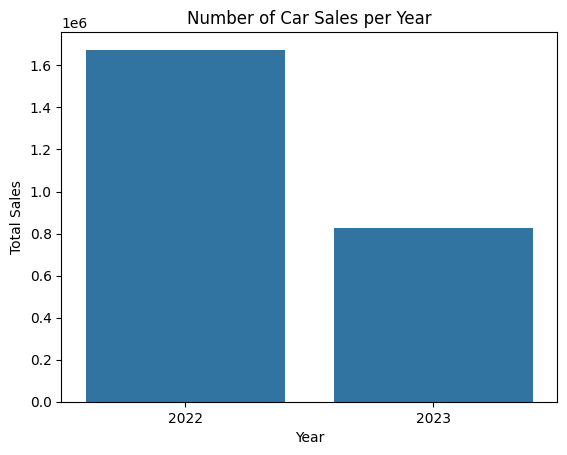

In [8]:
plt.figure()
sb.barplot(data=df_annual, x="year", y="total_sales")
plt.title("Number of Car Sales per Year")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.savefig("../images/number_of_car_sales_per_year.png", dpi=300)
plt.show()

The dataset shows a total of 1,674,502 car sales in 2022 and 825,498 in 2023. Sales volume in 2023 is significantly lower than in 2022, with approximately half as many recorded transactions. Although a sharp decline in sales is evident in 2023, the dataset does not provide sufficient information to determine the underlying causes of this decrease.

In [9]:
#   Number of sales per month (aggregated across all years)

pipeline = [
    {
        "$group": {
            "_id": "$month", 
            "total_sales": {"$sum": 1}
        }
    },
    {"$sort": {"_id": 1}}
]
result = list(collection.aggregate(pipeline))
df_monthly = pd.DataFrame(result)
df_monthly.rename(columns={"_id": "month"}, inplace=True)
df_monthly["month"] = df_monthly["month"].map({1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"})

df_monthly

,month,total_sales
0,Jan,211693
1,Feb,191524
2,Mar,211459
3,Apr,203983
4,May,218840
5,Jun,205421
6,Jul,211428
7,Aug,211446
8,Sep,204798
9,Oct,212586


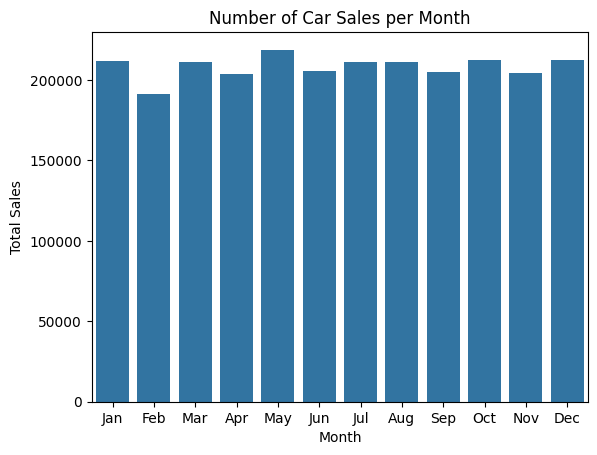

In [12]:
plt.figure()
sb.barplot(data=df_monthly, x="month", y="total_sales")
plt.title("Number of Car Sales per Month")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.savefig("../images/number_of_car_sales_per_month.png", dpi=300)
plt.show()

The monthly sales data shows fluctuations throughout the year, with May having the highest sales (218,840) and February the lowest (191,524). This monthly breakdown allows the analysis of seasonal trends and peak sales periods. However, the overall difference between months is not substantial, suggesting consistent sales activity throughout the year.

In [13]:
#   Number of sales per quarter (aggregated across all years)

pipeline = [
    {
        "$group": {
            "_id": "$quarter",
            "total_sales": {"$sum": 1}
        }
    },
    {"$sort": {"_id": 1}}
]

result = list(collection.aggregate(pipeline))
df_quarterly = pd.DataFrame(result)
df_quarterly.rename(columns={"_id":"quarter"}, inplace=True)

df_quarterly

,quarter,total_sales
0,1,614676
1,2,628244
2,3,627672
3,4,629408


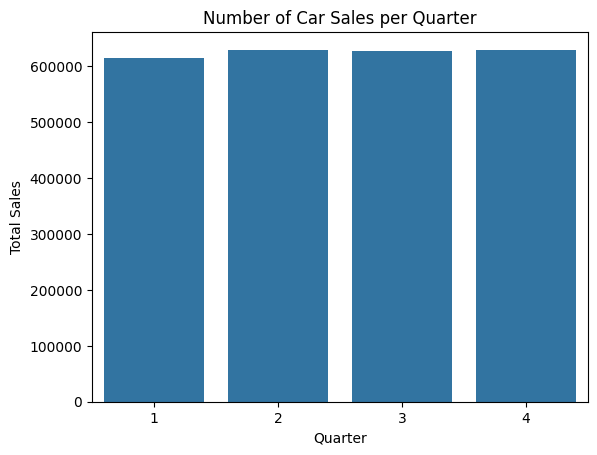

In [15]:
plt.figure()
sb.barplot(data=df_quarterly, x="quarter", y="total_sales")
plt.title("Number of Car Sales per Quarter")
plt.xlabel("Quarter")
plt.ylabel("Total Sales")
plt.savefig("../images/number_of_car_sales_per_quarter.png", dpi=300)
plt.show()

Quarterly aggregation shows that sales are fairly evenly distributed across the four quarters, with Q2 and Q4 slightly higher.

In [20]:
#   Number of sales per day of the week

pipeline = [
    {
        "$group": {
            "_id": "$day_of_week", 
            "total_sales": {"$sum": 1}
            }
    },
    {"$sort": {"_id": 1}}
]
result = list(collection.aggregate(pipeline))
df_daily = pd.DataFrame(result)
df_daily.rename(columns={"_id":"day_of_week"}, inplace=True)
df_daily["day_of_week"] = df_daily["day_of_week"].map({0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"})

df_daily

,day_of_week,total_sales
0,Mon,361773
1,Tue,355818
2,Wed,354875
3,Thu,355196
4,Fri,355302
5,Sat,355140
6,Sun,361896


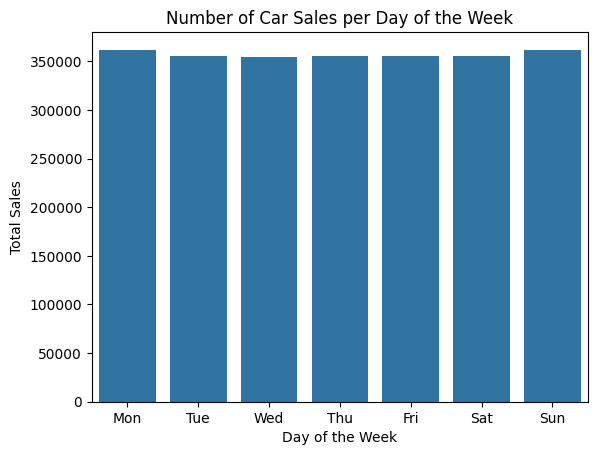

In [22]:
plt.figure()
sb.barplot(data=df_daily, x="day_of_week", y="total_sales")
plt.title("Number of Car Sales per Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Sales")
plt.savefig("../images/number_of_car_sales_per_day_of_the_week.png", dpi=300)
plt.show()

Sales by day of the week show that Monday and Sunday have slightly higher sales compared to other days, while Wednesday has the lowest. This daily distribution can help identify patterns in consumer behavior.

2. `Are there significant differences in car sale prices depending on the make, model, and year of manufacture?`

In [23]:
#   Average price by car make

pipeline = [
    {
        "$group": {
            "_id": "$car_make", 
            "avg_price": {
                "$avg": "$sale_price"
            }
        }
    },
    {"$sort": {"avg_price": -1}}
]
result = list(collection.aggregate(pipeline))
df_avg_price_make = pd.DataFrame(result)
df_avg_price_make.rename(columns={"_id":"car_make"}, inplace=True)
df_avg_price_make["avg_price"]=round(df_avg_price_make["avg_price"], 2)

df_avg_price_make

,car_make,avg_price
0,Honda,30032.53
1,Nissan,30016.45
2,Chevrolet,30015.43
3,Toyota,30001.99
4,Ford,29994.46


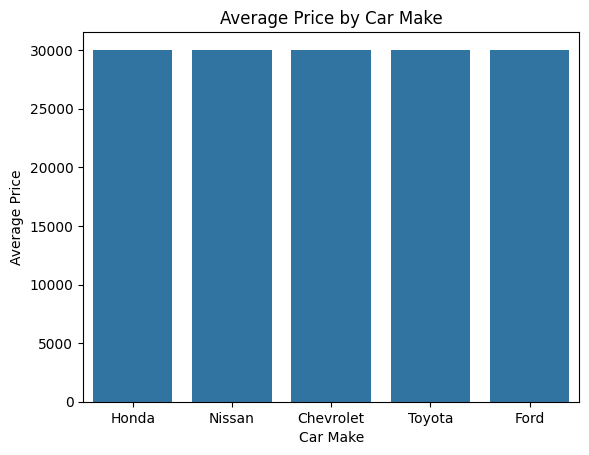

In [25]:
plt.figure()
sb.barplot(data=df_avg_price_make, x="car_make", y="avg_price")
plt.title("Average Price by Car Make")
plt.xlabel("Car Make")
plt.ylabel("Average Price")
plt.savefig("../images/average_price_by_car_make.png", dpi=300)
plt.show()

The average sale price varies slightly between car makes, ranging from approximately $29,994 for Ford to $30,032 for Honda. The overall variation is minimal, indicating that car make alone does not strongly influence the sale price in this dataset.

In [26]:
#   Average price by car model

pipeline = [
    {
        "$group": {
            "_id": "$car_model",
            "avg_price": {
                "$avg": "$sale_price"
            }
        }
    },
    {"$sort": {"avg_price": -1}}
]

result = list(collection.aggregate(pipeline))
df_avg_price_model = pd.DataFrame(result)
df_avg_price_model.rename(columns={"_id": "car_model"}, inplace=True)
df_avg_price_model['avg_price'] = df_avg_price_model['avg_price'].round(2)

df_avg_price_model

,car_model,avg_price
0,Silverado,30030.18
1,Corolla,30023.82
2,Altima,30022.04
3,F-150,29995.52
4,Civic,29989.34


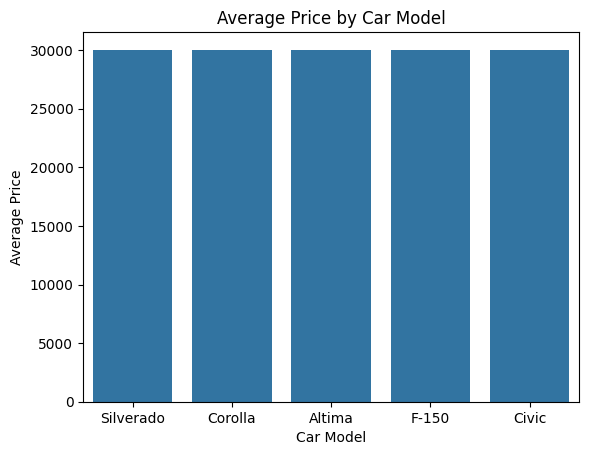

In [27]:
plt.figure()
sb.barplot(data=df_avg_price_model, x="car_model", y="avg_price")
plt.title("Average Price by Car Model")
plt.xlabel("Car Model")
plt.ylabel("Average Price")
plt.savefig("../images/average_price_by_car_model.png", dpi=300)
plt.show()

When grouped by car model, average prices are again very close, ranging from about $29,989 for the Civic to $30,030 for the Silverado.

In [29]:
#   Do different car makes have different prices for the same model?

pipeline = [
    {
        "$group": {
            "_id": {
                "car_make": "$car_make",
                "car_model": "$car_model"
            },
            "avg_price": {
                "$avg": "$sale_price"
            }
        }
    },
    {"$sort": {
        "_id.car_model": 1,
        "avg_price": -1
    }}
]

result = list(collection.aggregate(pipeline))

formatted_results = []
for doc in result:
    formatted_results.append({
        'car_make': doc['_id']['car_make'],
        'car_model': doc['_id']['car_model'],
        'avg_price': round(doc['avg_price'], 2)
    })

df_make_model = pd.DataFrame(formatted_results)

df_make_model

,car_make,car_model,avg_price
0,Nissan,Altima,30054.99
1,Chevrolet,Altima,30047.79
2,Ford,Altima,30034.73
3,Honda,Altima,30027.56
4,Toyota,Altima,29945.61
5,Honda,Civic,30006.80
6,Chevrolet,Civic,30004.23
7,Toyota,Civic,29982.90
8,Ford,Civic,29981.14
9,Nissan,Civic,29971.42


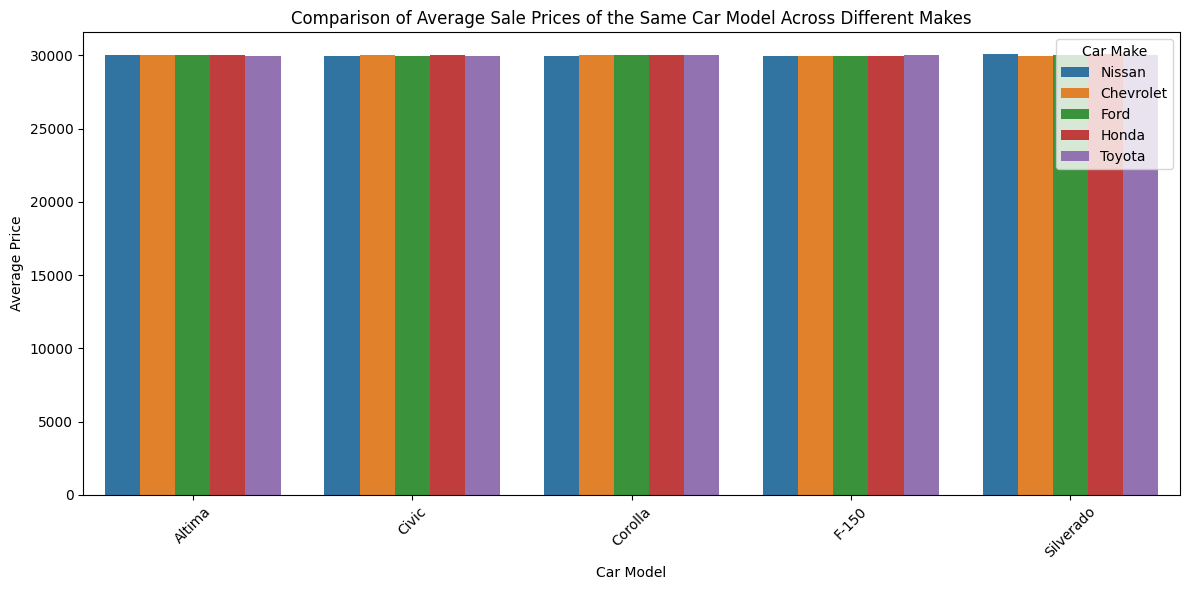

In [31]:
plt.figure(figsize=(12,6))
sb.barplot(
    data=df_make_model,
    x='car_model',
    y='avg_price',
    hue='car_make'
)
plt.title("Comparison of Average Sale Prices of the Same Car Model Across Different Makes")
plt.xlabel("Car Model")
plt.ylabel("Average Price")
plt.legend(title="Car Make")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../images/average_price_comparison_same_model_different_makes.png", dpi=300)
plt.show()

This chart compares the average sale price of the same car model across different makes. The results show that price differences between brands for a given model are very small, typically only a few dollars. For the same model, e.g. Altima, prices differ slightly across brands ($29,945–$30,055). This shows that both brand and model have a minor influence on sale prices.

In [33]:
#   Average price by year of production

pipeline = [
    {
        "$group": {
            "_id": "$car_production_year", 
            "avg_price": {
                "$avg": "$sale_price"
            }
        }
    },
    {"$sort": {"_id": 1}}
]
result = list(collection.aggregate(pipeline))
df_avg_price_prod_year = pd.DataFrame(result)
df_avg_price_prod_year.rename(columns={"_id": "prod_year"}, inplace=True)
df_avg_price_prod_year['avg_price'] = df_avg_price_prod_year['avg_price'].round(2)

df_avg_price_prod_year

,prod_year,avg_price
0,2010,30040.98
1,2011,29989.10
2,2012,30013.26
3,2013,29980.54
4,2014,30024.59
5,2015,30049.84
6,2016,30046.80
7,2017,30029.78
8,2018,29998.92
9,2019,30006.92


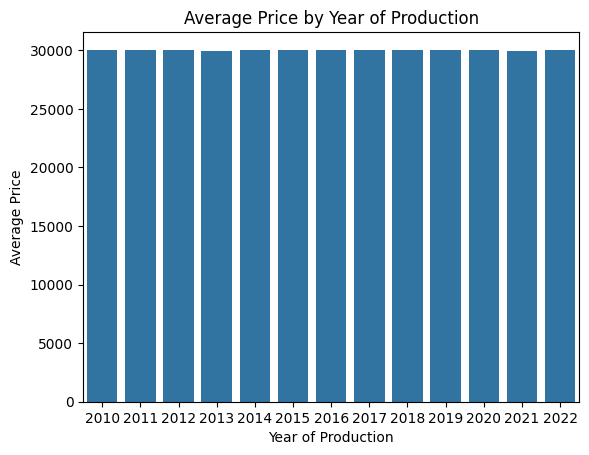

In [40]:
plt.figure()
sb.barplot(data=df_avg_price_prod_year, x="prod_year", y="avg_price")
plt.title("Average Price by Year of Production")
plt.xlabel("Year of Production")
plt.ylabel("Average Price")
plt.savefig("../images/average_price_by_year_of_production.png", dpi=300)
plt.show()

Average prices across production years remain very stable, fluctuating only slightly between ~$29,974 (2021) and ~$30,049 (2015). There is no clear upward or downward trend, indicating that production year has minimal impact on the average sale price in this dataset.

3. `Which car makes and models achieve the highest sales volume and the highest average sale price?`

In [36]:
#   Which car make has the highest sales volume?

pipeline = [
    {
        "$group": {
            "_id": "$car_make",
            "total_sales": {"$sum": 1},
            "total_revenue": {
                "$sum": "$sale_price"
            }
        }
    },
    {"$sort": {"total_sales": -1}}  
]

result = list(collection.aggregate(pipeline))
df_sales_by_make = pd.DataFrame(result)
df_sales_by_make.rename(columns={"_id": "car_make"}, inplace=True)

total_all_sales = df_sales_by_make['total_sales'].sum()
df_sales_by_make['market_share'] = (df_sales_by_make['total_sales'] / total_all_sales * 100).round(2)

df_sales_by_make

,car_make,total_sales,total_revenue,market_share
0,Honda,500687,15036898624,20.03
1,Chevrolet,500455,15021372800,20.02
2,Toyota,500147,15005405240,20.01
3,Ford,499781,14990661833,19.99
4,Nissan,498930,14976108358,19.96


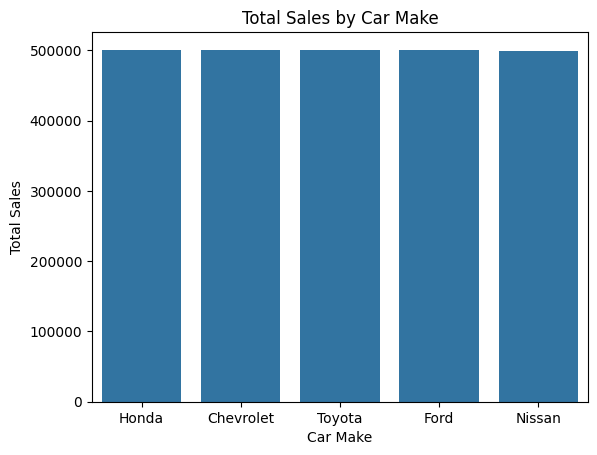

In [41]:
plt.figure()
sb.barplot(data=df_sales_by_make, x="car_make", y="total_sales")
plt.title("Total Sales by Car Make")
plt.xlabel("Car Make")
plt.ylabel("Total Sales")
plt.savefig("../images/total_sales_by_car_make.png", dpi=300)
plt.show()

The query shows the car makes with the highest sales volume. Honda leads slightly with 500,687 units sold, followed very closely by Chevrolet, Toyota, Ford, and Nissan. The differences in units sold are relatively small (less than 1,800 units between the highest and lowest in this top 5). Each of these brands holds roughly 20% of the market share, indicating a very evenly distributed market among the leading manufacturers. The total revenue figures reflect the high sales volume, with Honda generating the highest total revenue. Overall, the results suggest a highly competitive market.

In [38]:
#   Which car model has the highest sales volume?

pipeline = [
    {
        "$group": {
            "_id": "$car_model",
            "total_sales": {"$sum": 1},
            "total_revenue": {
                "$sum": "$sale_price"
            }
        }
    },
    {"$sort": {"total_sales": -1}}
]

result = list(collection.aggregate(pipeline))
df_sales_by_model = pd.DataFrame(result)
df_sales_by_model.rename(columns={"_id": "car_model"}, inplace=True)

total_all_sales = df_sales_by_model['total_sales'].sum()
df_sales_by_model['market_share'] = (df_sales_by_model['total_sales'] / total_all_sales * 100).round(2)

df_sales_by_model

,car_model,total_sales,total_revenue,market_share
0,Silverado,500842,15040374937,20.03
1,Civic,500498,15009604790,20.02
2,Corolla,500162,15016772687,20.01
3,F-150,499679,14988132564,19.99
4,Altima,498819,14975561877,19.95


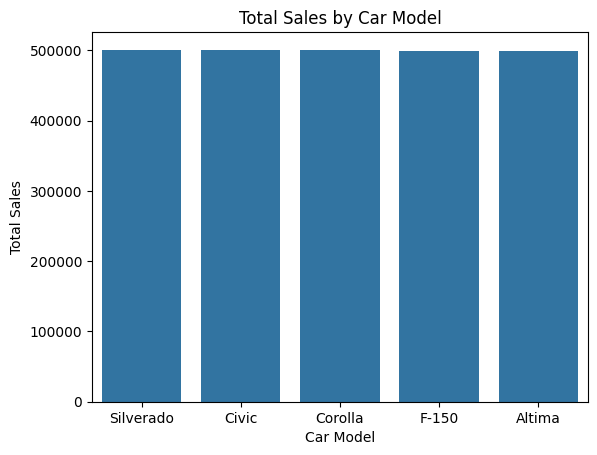

In [42]:
plt.figure()
sb.barplot(data=df_sales_by_model, x="car_model", y="total_sales")
plt.title("Total Sales by Car Model")
plt.xlabel("Car Model")
plt.ylabel("Total Sales")
plt.savefig("../images/total_sales_by_car_model.png", dpi=300)
plt.show()

The results for the query examining the top-selling car models are very similar to the previous query for car makes. The Silverado leads with 500,842 units sold, followed by the Civic (500,498), Corolla (500,162), F-150 (499,679), and Altima (498,819). Each model holds roughly 20% of the market share, and total revenue for the top model is just over 15 billion. Overall, the results highlight that the market for top-selling car models is tightly contested, with no single model dominating significantly.

In [43]:
#   Top 10 best-selling cars

pipeline = [
    {
        "$group": {
            "_id": {
                "car_make": "$car_make",
                "car_model": "$car_model"
            },
            "total_sales": {"$sum": 1},
            "total_revenue": {
                "$sum": "$sale_price"
            }
        }
    },
    {"$sort": {"total_sales": -1}},
    {"$limit": 10}
]

result = list(collection.aggregate(pipeline))

formatted_results = []
for doc in result:
    formatted_results.append({
        'car_make': doc['_id']['car_make'],
        'car_model': doc['_id']['car_model'],
        'total_sales': doc['total_sales'],
        'total_revenue': doc['total_revenue'],
    })

df_best_selling = pd.DataFrame(formatted_results)
df_best_selling['make_model'] = df_best_selling['car_make'] + ' ' + df_best_selling['car_model']

df_best_selling[['make_model', 'total_sales', 'total_revenue']]

,make_model,total_sales,total_revenue
0,Honda Silverado,100695,3027703645
1,Honda Civic,100511,3016012991
2,Chevrolet Civic,100430,3013324672
3,Ford Silverado,100295,3008826514
4,Toyota Corolla,100289,3009066503
5,Toyota Altima,100257,3002256675
6,Chevrolet Silverado,100209,3005535767
7,Ford Corolla,100175,3007434003
8,Chevrolet F-150,100151,3004034548
9,Toyota F-150,100124,3010015196


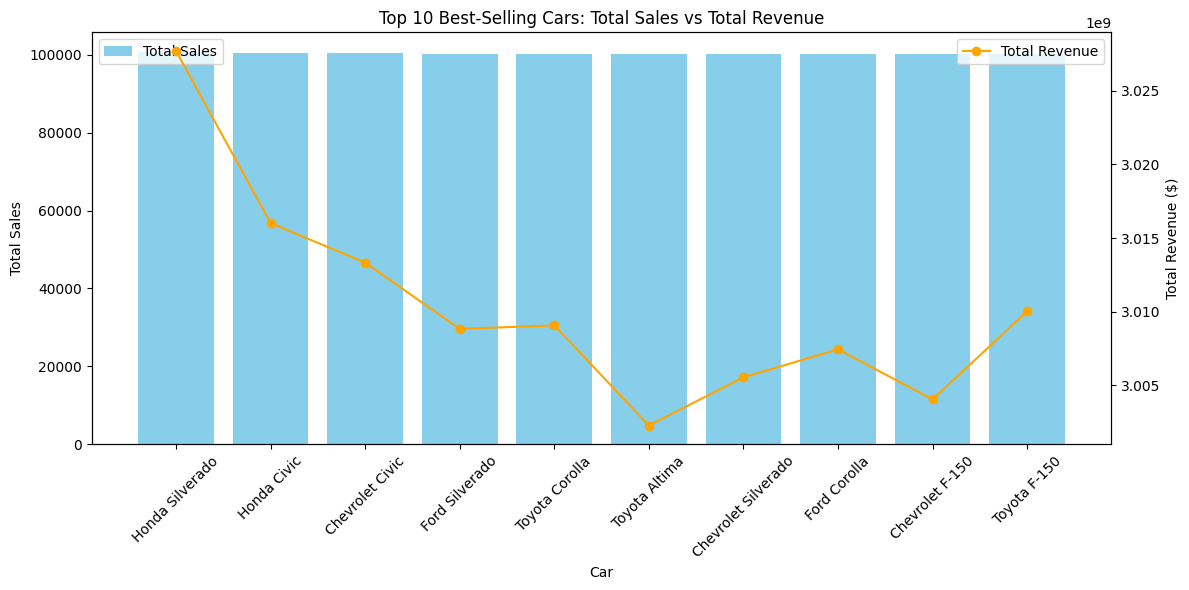

In [47]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(df_best_selling['make_model'], df_best_selling['total_sales'], color='skyblue', label='Total Sales')
ax1.set_xlabel('Car')
ax1.set_ylabel('Total Sales')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_best_selling['make_model'], df_best_selling['total_revenue'], color='orange', marker='o', label='Total Revenue')
ax2.set_ylabel('Total Revenue ($)')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Top 10 Best-Selling Cars: Total Sales vs Total Revenue')
plt.tight_layout()
plt.savefig("../images/top_10_best_selling_cars.png", dpi=300)
plt.show()


This query shows the top 10 best-selling cars. Honda Silverado leads with 100,695 units sold, followed by Honda Civic (100,511) and Chevrolet Civic (100,430). All top 10 cars have sales around 100,000 units. There are differences in total revenue among the top-selling vehicle models. The Honda Silverado generated the highest total revenue, while the Toyota Altima generated the lowest total revenue.

In [48]:
#   Top 10 cars with the highest average sale price

pipeline = [
    {
        "$group": {
            "_id": {
                "car_make": "$car_make",
                "car_model": "$car_model"
            },
            "avg_price": {
                "$avg": "$sale_price"
            }
        }
    },
    {"$sort": {"avg_price": -1}},
    {"$limit": 10}
]

result = list(collection.aggregate(pipeline))

formatted_results = []
for doc in result:
    formatted_results.append({
        'car_make': doc['_id']['car_make'],
        'car_model': doc['_id']['car_model'],
        'avg_price': doc['avg_price'],
    })

df_highest_avg_price = pd.DataFrame(formatted_results)
df_highest_avg_price['make_model'] = df_highest_avg_price['car_make'] + ' ' + df_highest_avg_price['car_model']

df_highest_avg_price[['make_model', 'avg_price']]

,make_model,avg_price
0,Nissan Silverado,30075.484461
1,Honda Silverado,30068.063409
2,Honda Corolla,30063.127904
3,Toyota F-150,30062.873996
4,Nissan Altima,30054.993238
5,Chevrolet Altima,30047.787871
6,Chevrolet Corolla,30037.657440
7,Ford Altima,30034.732935
8,Honda Altima,30027.563590
9,Ford Corolla,30021.801877


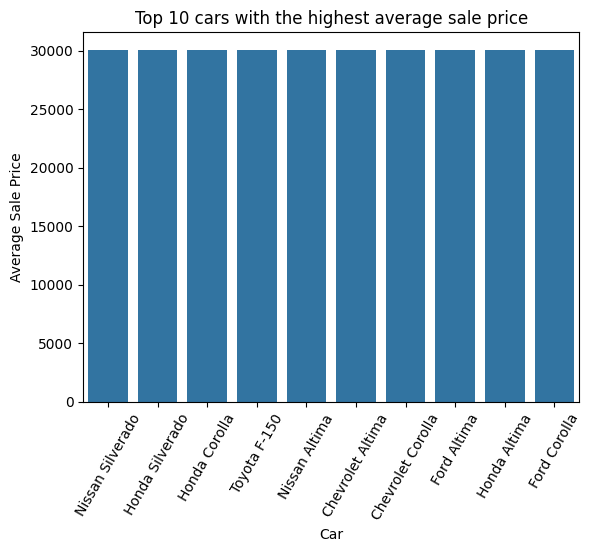

In [53]:
plt.figure()
sb.barplot(data=df_highest_avg_price, x="make_model", y="avg_price")
plt.xticks(rotation=60)
plt.title("Top 10 cars with the highest average sale price")
plt.xlabel("Car")
plt.ylabel("Average Sale Price")
plt.savefig("../images/top_10_average_price.png", dpi=300)
plt.show()

This query shows the top 10 cars with the highest average sale price. Nissan Silverado has the highest average at $30,075, followed closely by Honda Silverado (30,068) and Honda Corolla ($30,063). The average prices for all top 10 cars range from approximately $30,020 to $30,075.

4. `What is the relationship between a car’s age and its sale price?`

In [54]:
pipeline = [
    {
        "$group": {
            "_id": "$car_age", 
            "avg_price": {
                "$avg": "$sale_price"
            }
        }
    },
    {"$sort": {"_id": 1}}
]
result = list(collection.aggregate(pipeline))
df_age_price = pd.DataFrame(result)
df_age_price.rename(columns={"_id": "car_age"}, inplace=True)
df_age_price['avg_price'] = df_age_price['avg_price'].round(2)

df_age_price

,car_age,avg_price
0,0,29979.06
1,1,29982.55
2,2,29994.39
3,3,30015.58
4,4,29999.78
5,5,30026.47
6,6,30062.00
7,7,30011.73
8,8,30034.06
9,9,30005.28


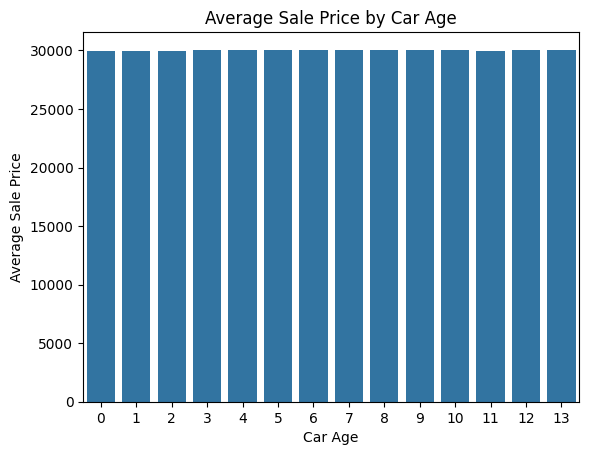

In [56]:
plt.figure()
sb.barplot(data=df_age_price, x="car_age", y="avg_price")
plt.title("Average Sale Price by Car Age")
plt.xlabel("Car Age")
plt.ylabel("Average Sale Price")
plt.savefig("../images/average_price_by_car_age.png", dpi=300)
plt.show()

This query shows the average sale price of cars comparing to their age. Prices fluctuate slightly between 29,961 and 30,062, with no clear trend, indicating that car age has a relatively small effect on the average sale price in this dataset.

5. `How does the commission rate affect earned commission, and do higher commission rates lead to higher total revenue?`

In [58]:
#   Total Commission by Commission Rate Ranges

pipeline = [
    {
        "$bucket": {
            "groupBy": "$commission_rate",
            "boundaries": [0.05, 0.07, 0.09, 0.11, 0.13, 0.16],
            "default": "Other",
            "output": {
                "total_commission": {"$sum": "$commission_earned"}
            }
        }
    },
    {"$sort": {"_id": 1}}
]

result = list(collection.aggregate(pipeline))

formatted_results = []
for doc in result:
    if doc['_id'] != "Other":
        start = doc['_id']
        boundaries = [0.05, 0.07, 0.09, 0.11, 0.13, 0.16]
        idx = boundaries.index(start)
        end = boundaries[idx + 1] if idx < len(boundaries) - 1 else 0.16
        rate_label = f"{start:.2f}-{end:.2f}"
    else:
        rate_label = "Other"
        
    formatted_results.append({
        'rate_range': rate_label,
        'total_commission': round(doc['total_commission'], 2)
    })

df_rate_ranges_total_commission = pd.DataFrame(formatted_results)

df_rate_ranges_total_commission

,rate_range,total_commission
0,0.05-0.07,9.019156e+08
1,0.07-0.09,1.200172e+09
2,0.09-0.11,1.498793e+09
3,0.11-0.13,1.799418e+09
4,0.13-0.16,2.102214e+09


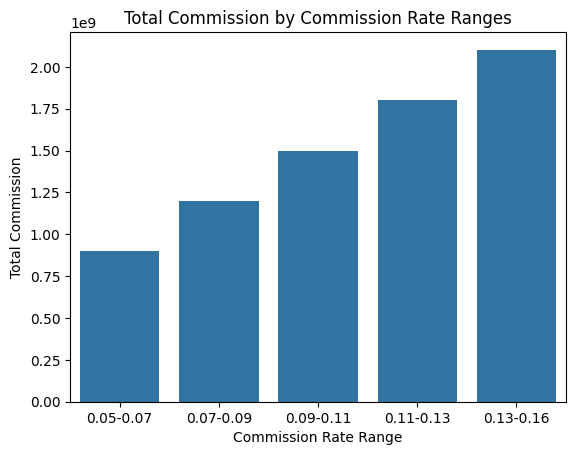

In [60]:
plt.figure()
sb.barplot(data=df_rate_ranges_total_commission, x="rate_range", y="total_commission")
plt.title("Total Commission by Commission Rate Ranges")
plt.xlabel("Commission Rate Range")
plt.ylabel("Total Commission")
plt.savefig("../images/total_commission_by_commission_rate_ranges.png", dpi=300)
plt.show()

This query examines how commission rate affects total earnings, with rates grouped into buckets. The results show that as the commission rate increases from 0.05–0.07 up to 0.13–0.16, the total earnings also increase, rising from approximately 901 million to 2.1 billion. Higher commission rates lead to significantly higher total earnings, highlighting the strong impact of commission percentage on overall revenue.

In [ ]:
#   Average Commission by Commission Rate Ranges

pipeline = [
    {
        "$bucket": {
            "groupBy": "$commission_rate",
            "boundaries": [0.05, 0.07, 0.09, 0.11, 0.13, 0.16],
            "default": "Other",
            "output": {
                "avg_commission": {"$avg": "$commission_earned"},
            }
        }
    },
    {"$sort": {"_id": 1}}
]

result = list(collection.aggregate(pipeline))

formatted_results = []
for doc in result:
    if doc['_id'] != "Other":
        start = doc['_id']
        boundaries = [0.05, 0.07, 0.09, 0.11, 0.13, 0.16]
        idx = boundaries.index(start)
        end = boundaries[idx + 1] if idx < len(boundaries) - 1 else 0.16
        rate_label = f"{start:.2f}-{end:.2f}"
    else:
        rate_label = "Other"
    
    formatted_results.append({
        'rate_range': rate_label,
        'avg_commission': round(doc['avg_commission'], 2),
    })

df_rate_ranges_avg_commission = pd.DataFrame(formatted_results)

df_rate_ranges_avg_commission

,rate_range,avg_commission
0,0.05-0.07,1800.32
1,0.07-0.09,2402.16
2,0.09-0.11,2999.93
3,0.11-0.13,3602.54
4,0.13-0.16,4201.83


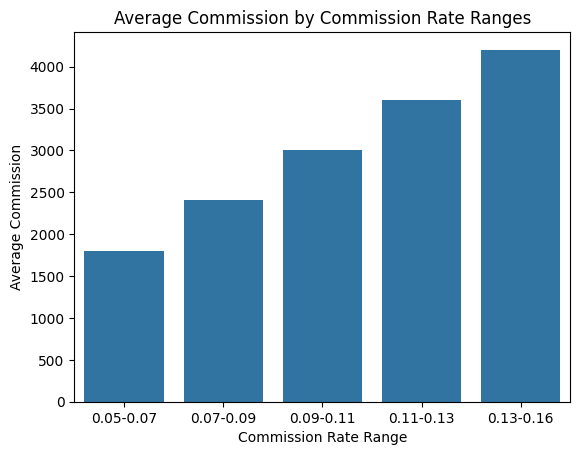

In [62]:
plt.figure()
sb.barplot(data=df_rate_ranges_avg_commission, x="rate_range", y="avg_commission")
plt.title("Average Commission by Commission Rate Ranges")
plt.xlabel("Commission Rate Range")
plt.ylabel("Average Commission")
plt.savefig("../images/average_commission_by_commission_rate_ranges.png", dpi=300)
plt.show()

This query examines how commission rate affects average commission, with rates grouped into buckets. The results show that as the commission rate increases from 0.05–0.07 up to 0.13–0.16, the average commission per sale rises from approximately 1,800 to 4,202. Higher commission rates lead to significantly higher average earnings, highlighting the strong impact of commission percentage on earnings per sale.

In [66]:
#   Correlation – Quantitative validation of the relationship between commission rate, sale price, and commission earned

pipeline = [
    {
        "$sample": {"size": 100000}
    },
    {
        "$project": {
            "commission_rate": 1,
            "commission_earned": 1,
            "sale_price": 1,
            "_id": 0
        }
    }
]

result = list(collection.aggregate(pipeline))
df_sample = pd.DataFrame(result)

#Correlation coefficients
corr_rate_earned = df_sample['commission_rate'].corr(df_sample['commission_earned'])
corr_price_earned = df_sample['sale_price'].corr(df_sample['commission_earned'])

print("Correlation coefficients:\n")
print(f"1. Commission Rate, Commission Earned:  {corr_rate_earned:.4f}\n")

if corr_rate_earned > 0.7:
    print(f"Interpretation: Strong positive relationship\n")
elif corr_rate_earned > 0.3:
    print(f"Interpretation: Moderate positive relationship\n")
elif corr_rate_earned > -0.3:
    print(f"Interpretation: Weak or negligible relationship\n")
else:
    print(f"Interpretation: Negative relationship\n")

print(f"2. Sale Price, Commission Earned:  {corr_price_earned:.4f}\n")

#Comparative impact analysis
print(f"\nComparative impact analysis:\n")
if abs(corr_price_earned) > abs(corr_rate_earned):
    diff_pct = ((abs(corr_price_earned) - abs(corr_rate_earned)) / abs(corr_rate_earned)) * 100
    print(f"Sale price has a stronger impact on commission earned ({diff_pct:.1f}% stronger correlation).\n")
    print(f"Conclusion: Selling higher-priced vehicles contributes more to commission earnings than applying higher commission rates.\n")
else:
    print(f"Commission rate has a stronger impact on commission earnings than the sale price.")

Correlation coefficients:

1. Commission Rate, Commission Earned:  0.5860

Interpretation: Moderate positive relationship

2. Sale Price, Commission Earned:  0.7799


Comparative impact analysis:

Sale price has a stronger impact on commission earned (33.1% stronger correlation).

Conclusion: Selling higher-priced vehicles contributes more to commission earnings than applying higher commission rates.



`Additional queries`

In [63]:
#   Total Commission Earned by Year

pipeline = [
    {
        "$group": {
            "_id": "$year",
            "total_commission": {
                "$sum": "$commission_earned"
            },
        }
    },
    {"$sort": {"_id": 1}}
]

result = list(collection.aggregate(pipeline))
df_total_commission_year = pd.DataFrame(result)
df_total_commission_year.rename(columns={"_id": "year"}, inplace=True)

df_total_commission_year

,year,total_commission
0,2022,5.024934e+09
1,2023,2.477579e+09


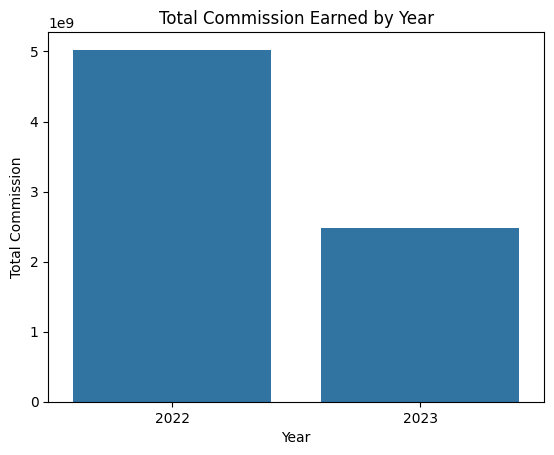

In [65]:
plt.figure()
sb.barplot(data=df_total_commission_year, x="year", y="total_commission")
plt.title("Total Commission Earned by Year")
plt.xlabel("Year")
plt.ylabel("Total Commission")
plt.savefig("../images/total_commission_by_year.png", dpi=300)
plt.show()

This query shows the total commission earned per year. In 2022, total commission was approximately 5.02 billion, while in 2023 it dropped to about 2.48 billion, mainly because the total number of sales was lower in 2023, resulting in reduced earnings.

In [68]:
#   Total Commission Earned by Quarter

pipeline = [
    {
        "$group": {
            "_id": "$quarter",
            "total_commission": {
                "$sum": "$commission_earned"
            },
        }
    },
    {"$sort": {"_id": 1}}
]

result = list(collection.aggregate(pipeline))
df_total_commission_quarter = pd.DataFrame(result)
df_total_commission_quarter.rename(columns={"_id": "quarter"}, inplace=True)

df_total_commission_quarter

,quarter,total_commission
0,1,1.843810e+09
1,2,1.885758e+09
2,3,1.883882e+09
3,4,1.889063e+09


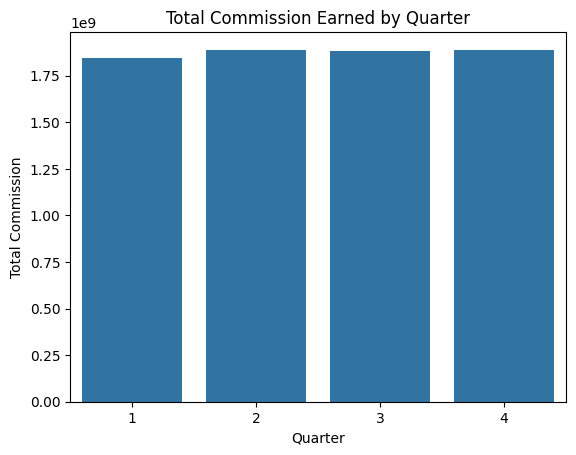

In [69]:
plt.figure()
sb.barplot(data=df_total_commission_quarter, x="quarter", y="total_commission")
plt.title("Total Commission Earned by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Total Commission")
plt.savefig("../images/total_commission_by_quarter.png", dpi=300)
plt.show()

This query shows the total commission earned per quarter. The earnings are relatively stable across the year, ranging from approximately 1.84 billion in Q1 to 1.89 billion in Q4, with only minor fluctuations between quarters.

`Conclusion`

The exploratory data analysis indicates that car make and model do not have a significant impact on either vehicle price or sales volume. Vehicles with comparable specifications are sold at very similar prices regardless of brand, and no meaningful differences in sales volume were observed across brands or models.

Sales volume remains relatively stable across days of the week, months, and quarters, suggesting the absence of strong seasonal or temporal sales patterns.

Despite the stability observed at the product and temporal level, a substantial decline in overall performance was identified at the aggregate level. In 2023, both total sales volume and total revenue were approximately half of those recorded in 2022. Given the absence of significant changes in pricing structure, brand effects, model differentiation, or temporal sales patterns, the decline in total revenue appears to be primarily associated with a reduction in overall sales volume rather than product- or time-related factors.

The analysis also shows that vehicle price has a significant influence on total revenue, while the commission rate exhibits a moderate effect. This implies that, although individual product differentiation does not play a major role, pricing strategy and production scale are key drivers of overall revenue.

Overall, the results suggest that macroeconomic or operational factors, such as production capacity or market conditions, are more influential in determining total revenue than brand differentiation, model choice, or short-term sales patterns.